# **Chapter 8 텍스트 분석**

### **[개념 정리]**

#### **10 텍스트 분석 실습 — 캐글 Mercari Price Suggestion Challenge**

데이터 세트의 속성
- train_id: 데이터 id
- name： 제품명
- item_conditionjd： 판매자가 제공하는 제품 상태
- category_name： 카테고리 명
- brand_name： 브랜드 이름
- price： 제품 가격. 예측을 위한 타깃 속성
- shipping： 배송비 무료 여부. 1 이면 무료(판매자가 지불), 0이면 유료(구매자 지불)
- item_description： 제품에 대한 설명

기존 회귀 예제와 다르게 item_description과 같은 텍스트 형태의 비정형 데이터와 다른 정형 속성을 같이 적용해 회귀 수행

##### **피처 인코딩과 피처 벡터화**

CountVectorizer, TfidfVectorizer가 fit_transform()을 통해 반환하는 데이터는 희소 행렬 형태
- 희소 행렬 객체 변수를 새로 결합해 새로운 데이터 세트를 구성해야하며, 원-핫 인코딩된 변수들도 모두 희소 행렬 객체 변수와 결합되어 ML 모델을 실행하는 기반 데이터 세트로 재구성해야 함
> 인코딩 대상 칼럼도 밀집 행렬 형태가 아닌 희소 행렬 형태로 인코딩을 적용 후 결합
> `LabelBinarizer` 클래스는 희소 행렬 형태의 인코딩 적용
> 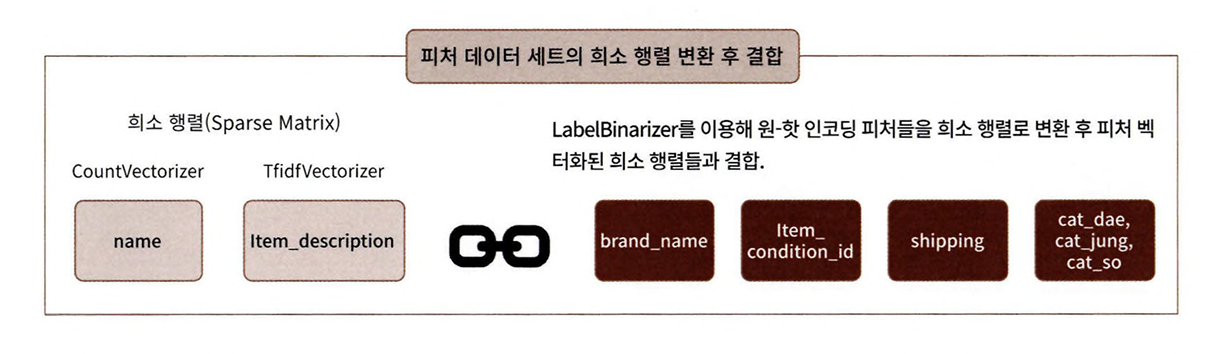

##### **릿지 회귀 모델 구축 및 평가**

RMSLE(Root Mean Sqaure Logarithmic Error)
- 오류 값에 log를 취해 RMSE를 구하는 방식
> 낮은 가격보다 높은 가격에서 오류가 발생할 경우 오류 값이 더 커지는 것을 억제하기 위해서 이 방식 사용
> 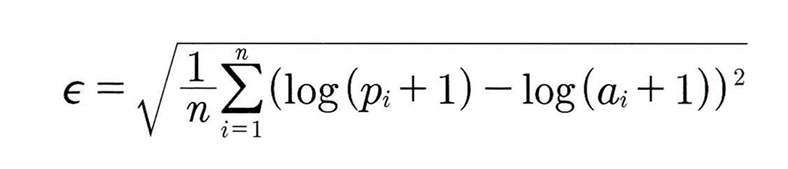

#### **11 정리**

ML 기반의 텍스트 분석 프로세스
1. 텍스트 사전 정제 작업 등의 텍스트 정규화 작업 수행
2. 이 단어들을 피처 벡터화로 변환
3. 이렇게 생성된 피처 벡터 데이터 세트에 머신러닝 모델을 학습하고 예측, 평가

텍스트 정규화
> 텍스트 클렌징 및 대소문자 변경
> 단어 토큰화
> 의미 없는 단어 필터링
> 어근 추출
위와 같은 피처 벡터화 진행 전 수행하는 다양한 사전 작업을 의미

피처 벡터화
- Count 기반 피처 벡터화
- TF-IDF 기반 피처 벡터화
> 일반적으로 문서의 문장이 긴 경우 TF-IDF 기반의 피처 벡터가 더 정확한 결과를 도출하는 데 도움이 됨

최종적으로 만들어진 피처 벡터 데이터 세트는 희소 행렬이며, ML 모델은 이러한 희소 행렬 기반에서 최적화 되어야 함

### **[필사]**

#### **10 텍스트 분석 실습 — 캐글 Mercari Price Suggestion Challenge**

##### **데이터 전처리**

In [114]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv('mercari_train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(212747, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3.0,Men/Tops/T-shirts,NaN,10.0,1.0,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3.0,Electronics/Computers & Tablets/Components & Parts,Razer,52.0,0.0,This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
2,2,AVA-VIV Blouse,1.0,Women/Tops & Blouses/Blouse,Target,10.0,1.0,"Adorable top with a hint of lace and a key hole in the back! The pale pink is a 1X, and I also have a 3X available in white!"


In [115]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212747 entries, 0 to 212746
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   train_id           212747 non-null  int64  
 1   name               212747 non-null  object 
 2   item_condition_id  212746 non-null  float64
 3   category_name      211835 non-null  object 
 4   brand_name         121819 non-null  object 
 5   price              212746 non-null  float64
 6   shipping           212746 non-null  float64
 7   item_description   212746 non-null  object 
dtypes: float64(3), int64(1), object(4)
memory usage: 13.0+ MB
None


Target 값인 price 컬럼의 데이터 분포도

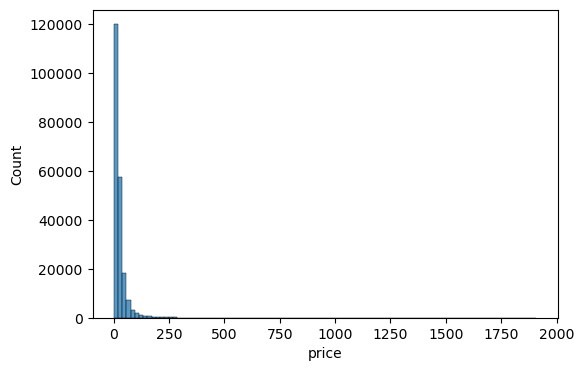

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.histplot(y_train_df, bins=100)
plt.show()

Price 칼럼 로그 변환

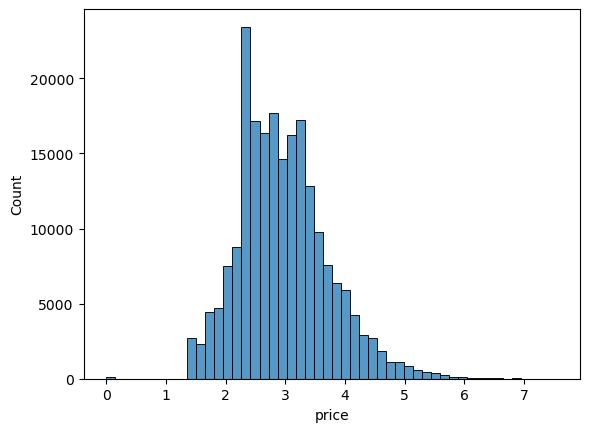

In [119]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.histplot(y_train_df, bins=50)
plt.show()

In [120]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

In [121]:
print('Shipping 값 유형:\n', mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형:\n', mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 shipping
0.0    117715
1.0     95031
Name: count, dtype: int64
item_condition_id 값 유형:
 item_condition_id
1.0    91677
3.0    62100
2.0    54077
4.0     4534
5.0      358
Name: count, dtype: int64


Shipping 칼럼은 배송비 유무
- 값이 비교적 균일

Item_condition_id 칼럼은 판매자가 제공하는 제품 상태
- Null 값이 별로 없지만, description에 대한 별도 설명이 없는 경우 'No description yet'값으로 되어 있음

In [123]:
boolean_cond = mercari_df['item_description'] == 'No description yet'
mercari_df[boolean_cond]['item_description'].count()

11967

In [124]:
# apply lambda에서 호출되는 대, 중, 소 분할 함수 생성, 대, 중, 소 값을 리스트로 반환
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_Null', 'Other_Null', 'Other_Null']

# 위의 split_cat()을 apply lambda에서 호출해 대, 중, 소 칼럼을 mercari_df에 생성.
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = zip(*mercari_df['category_name'].apply(lambda x: split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 개수만 추출
print('대분류 유형: \n', mercari_df['cat_dae'].value_counts())
print('중분류 유형: ', mercari_df['cat_jung'].nunique())
print('소분류 유형: ', mercari_df['cat_so'].nunique())

대분류 유형: 
 cat_dae
Women                     95521
Beauty                    29821
Kids                      24634
Electronics               17538
Men                       13534
Home                       9695
Vintage & Collectibles     6606
Other                      6512
Handmade                   4377
Sports & Outdoors          3597
Other_Null                  912
Name: count, dtype: int64
중분류 유형:  114
소분류 유형:  759


brand_name, category_name, item_description 칼럼의 Null 값은 일괄적으로 'Other Null'로 동일하게 변경

In [126]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

# 추가 Null 처리
mercari_df['item_condition_id'] = mercari_df['item_condition_id'].fillna(0)
mercari_df['shipping'] = mercari_df['shipping'].fillna(0)
mercari_df['price'] = mercari_df['price'].fillna(0)

# 각 칼럼별로 Null 값 건수 확인. 모두 0이 나와야 합니다.
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

##### **피처 인코딩과 피처 벡터화**

brand_name

In [129]:
print('brand name의 유형 건수: ', mercari_df['brand_name'].nunique())
print('brand name sample 5건: \n', mercari_df['brand_name'].value_counts()[:5])

brand name의 유형 건수:  2735
brand name sample 5건: 
 brand_name
Other_Null           90928
PINK                  7812
Nike                  7653
Victoria's Secret     6933
LuLaRoe               4503
Name: count, dtype: int64


name

In [131]:
print('name의 종류 개수: ', mercari_df['name'].nunique())
print('name sample 7건: \n', mercari_df['name'].value_counts()[:7])

name의 종류 개수:  194949
name sample 7건: 
 name
Bundle                  317
Dress                    67
Reserved                 62
Converse                 59
American Eagle Jeans     58
BUNDLE                   54
Nike                     50
Name: count, dtype: int64


name 속성의 경우 종류가 매우 많음
- 유형이 매우 많고, 적은 단어 위주의 텍스트 형태로 되어 있으므로 Count 기반으로 피처 벡터화 변환을 적용

item_description

In [134]:
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 크기
print('item_description 평균 문자열 크기:', mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 문자열 크기: 145.404898776481


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

평균 문자열이 145자로 비교적 크므로 해당 칼럼은 TF-IDF로 변환

name은 CountVectorizer, item_description은 TfidfVectorizer로 변환

In [137]:
# name 속성에 대한 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description에 대한 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features = 50000, ngram_range = (1, 3), stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:', X_name.shape)
print('item_description vectorization shape: ', X_descp.shape)

name vectorization shape: (212747, 37381)
item_description vectorization shape:  (212747, 50000)


LabelBinarizer로 원-핫 인코딩 변환

In [140]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])
lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])
lb_shipping = LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])
lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])
lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [144]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand shape：{0}, X_item_cond_id shape：{1}'.format(X_brand.shape, X_item_cond_id.shape)) 
print('X_shipping shape：{0}, X_cat_dae shape：{1}'.format(X_shipping.shape, X_cat_dae.shape)) 
print('X_cat_jung shape：{0}, X_cat_so shape：{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
X_brand shape：(212747, 2735), X_item_cond_id shape：(212747, 6)
X_shipping shape：(212747, 1), X_cat_dae shape：(212747, 11)
X_cat_jung shape：(212747, 114), X_cat_so shape：(212747, 759)


피처 벡터화 변환한 데이터 세트와 희소 인코딩 변환된 데이터 세트를 hstack()를 이용해 모두 결합

In [149]:
from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합.
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 세트가 메모리를 많이 차지하므로 사용 목적이 끝났으면 바로 메모리에서 삭제.
del X_features_sparse
gc.collect()

<class 'scipy.sparse._csr.csr_matrix'> (212747, 91007)


1950

##### **릿지 회귀 모델 구축 및 평가**

In [154]:
def rmsle(y, y_pred):
    # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test, preds):

    # 원본 데이터는 log1p로 변환되었으므로 expm1로 복구 필요.
    preds_expm = np.expm1(preds)
    y_test_expm = np.expm1(y_test)

    # rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_expm, preds_expm)
    return rmsle_result

In [156]:
import gc
from scipy.sparse import hstack

def model_train_predict(model, matrix_list):
    # scipy.sparse 모듈의 hstack을 이용해 희소 행렬 결합
    X = hstack(matrix_list).tocsr()

    X_train, X_test, y_train, y_test = train_test_split(X, mercari_df['price'], test_size=0.2, random_state=156)

    # 모델 학습 및 예측
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    del X, X_train, X_test, y_train
    gc.collect()

    return preds, y_test

In [158]:
linear_model = Ridge(solver='lsqr', fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값: ', evaluate_org_price(y_test, linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값: ', evaluate_org_price(y_test, linear_preds))

Item Description을 제외했을 때 rmsle 값:  0.5161813260840469
Item Description을 포함한 rmsle 값:  0.4969180186079901


Item Description을 포함했을 때 rmsle값이 감소
> Item Description 영향이 중요함을 알 수 있음

##### **LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가**

In [164]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds, y_test = model_train_predict(model=lgbm_model, matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값: ', evaluate_org_price(y_test, lgbm_preds))

C:\Users\won-0\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 37.592225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 795076
[LightGBM] [Info] Number of data points in the train set: 170197, number of used features: 30601
[LightGBM] [Info] Start training from score 2.977820


C:\Users\won-0\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM rmsle 값:  0.5086161845945246


앞 Ridge보다 예측 성능이 더 나아짐

LightGBM과 Ridge을 서로 앙상블하여 최종 예측 결괏값 도출

In [166]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값: ', evaluate_org_price(y_test, preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값:  0.47847115743298324
